In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
import time

In [10]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
from typing import Callable, List, Optional, Tuple
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from IPython.display import clear_output

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bert_tokenizer, bert_model, max_length):

        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str, progress) -> torch.tensor:
        
        
        print(progress, flush=True)
        
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        
        clear_output(wait=True)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string, f'{text.index(string) + 1}/{len(text)}') for string in text])


In [134]:
X = 'nlp_3', 'nlp_2', 'nlp_5',
Y = 'GDT_score'
DATASET = 'NLP_FULLSTOPS.xlsx'

In [135]:
df = pd.read_excel(io=DATASET)

In [136]:
bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [137]:
all_x = []

for item in X:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

Y = df[Y]
X.shape


nlp_5 added to list


(522, 2304)

In [328]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=0)

In [329]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(16, activation='relu'),
                             tf.keras.layers.Dense(8, activation='relu'),
                             tf.keras.layers.Dense(units=1),

])

In [330]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_absolute_error')
            #   loss=tf.keras.losses.BinaryCrossentropy(),
            #   metrics=['accuracy'])

In [331]:
history = model.fit(
    train_features,
    train_labels,
    epochs=40,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [332]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
35,1.781710,2.894321,35
36,1.793053,2.862717,36
37,1.735343,2.861710,37
38,1.716106,2.846885,38
39,1.681603,2.847685,39


In [333]:
results = model.predict(test_features)

4/4 [==============================] - 0s 3ms/step


In [334]:
results = [int(item) for item in results]

In [335]:
from scipy import stats
results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, test_labels))

PearsonRResult(statistic=0.5811163741634893, pvalue=8.070124914828621e-11)


In [336]:
answers_tuples = [(y, res) for y, res in zip(test_labels, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

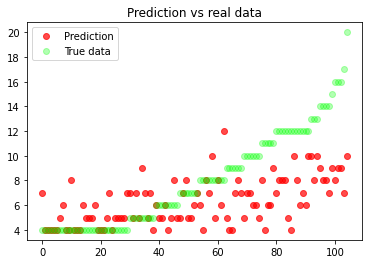

In [337]:
plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='True data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data')
plt.show()